In [1]:
#imported libraries
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import os
import rasterio
import numpy as np
from rasterio.transform import from_origin
from rasterio import features
import shapely
from rasterio.features import rasterize
from rasterio.enums import MergeAlg
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from geopy.distance import geodesic
from shapely.ops import nearest_points

from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap, truncate_colormap


In [2]:
#merge datasets
def merge_datasets():
    dataset_path_data = ""
    timestep = 0
    df = pd.DataFrame()

    for j in range(1, 13):
        timestep += 1
        dataset_path_data = f"2018-{j:02d}"

        temp_df1 = pd.read_csv(f"data/crime/{dataset_path_data}-metropolitan-street.csv")
        temp_df2 = pd.read_csv(f"data/crime/{dataset_path_data}-city-of-london-street.csv")

        temp_df1 = temp_df1[['Month', 'Longitude', 'Latitude', 'Crime type']]
        temp_df2 = temp_df2[['Month', 'Longitude', 'Latitude', 'Crime type']]

        # Merge both datasets
        temp_df = pd.concat([temp_df1, temp_df2], ignore_index=True)
        temp_df['timestep'] = timestep
        df = pd.concat([df, temp_df], ignore_index=True)

    temp_wards = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df.Longitude, df.Latitude),
    )
    temp_wards.set_crs(epsg=4326, inplace=True)  # First assign WGS84 CRS

    return(temp_wards)

In [3]:
# create the shape file for the wards
shapefile_dir = 'data\LB_shp'
gdfs = []
#import all the different districts and their wards
for file in os.listdir(shapefile_dir):
    if file.endswith('.shp'):
        filepath = os.path.join(shapefile_dir, file)
        gdf = gpd.read_file(filepath)
        gdfs.append(gdf)
#merge them into one gdf
merged_gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))
merged_gdf.crs

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.01, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [4]:
#Read the crimedata
df = merge_datasets()
df = df[['Month','Longitude','Latitude','Crime type']]

#filter all burgleies
burglaries = df[df['Crime type']=="Burglary"]
#convert to gdf
b_gdf = gpd.GeoDataFrame(
    burglaries, 
    geometry=gpd.points_from_xy(burglaries.Longitude, burglaries.Latitude),
)
#correct css
b_gdf.set_crs(epsg=4326, inplace=True) 
#b_gdf.explore()

,Month,Longitude,Latitude,Crime type,geometry
12,2018-01,0.140035,51.589112,Burglary,POINT (0.14004 51.58911)
13,2018-01,0.140035,51.589112,Burglary,POINT (0.14004 51.58911)
14,2018-01,0.140035,51.589112,Burglary,POINT (0.14004 51.58911)
15,2018-01,0.135554,51.584985,Burglary,POINT (0.13555 51.58498)
34,2018-01,0.127794,51.584191,Burglary,POINT (0.12779 51.58419)
...,...,...,...,...,...
1063060,2018-12,-0.078779,51.508971,Burglary,POINT (-0.07878 51.50897)
1063078,2018-12,NaN,NaN,Burglary,POINT EMPTY
1063079,2018-12,NaN,NaN,Burglary,POINT EMPTY
1063080,2018-12,NaN,NaN,Burglary,POINT EMPTY


In [5]:
# Read the CSV train stations
df = pd.read_csv('data/converted_stations.csv')

df = df[['StationUniqueId','Lon','Lat']]
df = df.rename(columns={'Lon': 'Longitude', 'Lat': 'Latitude'})



t_gdf = gpd.GeoDataFrame(
    df, 
    geometry=gpd.points_from_xy(df.Longitude, df.Latitude),
)
#correct css
t_gdf.set_crs(epsg=4326, inplace=True) 
#t_gdf.explore()

,StationUniqueId,Longitude,Latitude,geometry
0,910GACTNCTL,-0.263507,51.508624,POINT (-0.26351 51.50862)
1,910GACTNCTL,-0.263717,51.506514,POINT (-0.26372 51.50651)
2,910GACTNCTL,-0.262602,51.508925,POINT (-0.2626 51.50892)
3,910GACTNCTL,-0.262930,51.508651,POINT (-0.26293 51.50865)
4,910GACTNCTL,-0.263059,51.508653,POINT (-0.26306 51.50865)
...,...,...,...,...
4059,HUBZWL,-0.060191,51.519430,POINT (-0.06019 51.51943)
4060,HUBZWL,-0.059759,51.519413,POINT (-0.05976 51.51941)
4061,HUBZWL,-0.059911,51.519578,POINT (-0.05991 51.51958)
4062,HUBZWL,-0.059837,51.519631,POINT (-0.05984 51.51963)


In [6]:
house_new_gdf = gpd.read_file('data/houseprices/London_House_Prices_2017_adjusted.shp')
house_new_gdf=house_new_gdf.to_crs(epsg=4326)
#house_new_gdf.explore()

In [7]:
locs = gpd.read_file("data\House_prices_London.gpkg")
# Change the CRS 
locs = locs.to_crs(epsg=27700)
prices = pd.read_csv("data\London_prices.csv")
prices = prices.rename(columns={'Postal Code': 'postcode'})

h_gdf = locs.merge(prices, on='postcode')
h_gdf['Price_per_Size'] = h_gdf['Price'] / h_gdf['Area in sq ft']
h_gdf=h_gdf[['postcode','Price_per_Size','geometry']]


In [8]:
# Read the CSV police stations stations
df = pd.read_csv('data/police_stations.csv')

df = df[['station_name',' long',' lat']]
#mistake in data
df = df.rename(columns={' long': 'Latitude', ' lat': 'Longitude'})

p_gdf = gpd.GeoDataFrame(
    df, 
    geometry=gpd.points_from_xy(df.Longitude, df.Latitude),
)
#correct css
p_gdf.set_crs(epsg=4326, inplace=True) 
p_gdf.explore()

In [9]:
#method to get all points in a certain ward and set the value equal to a column value of that ward
def neighborhood_amount(points,wards,col_name):
    wards = wards.drop(columns=["index_right"], errors="ignore")
    points_with_polygons = gpd.sjoin(points, wards, how="inner")
    #print(points_with_polygons.columns)
    point_counts = points_with_polygons.groupby("index_right").size()
    wards[col_name] = wards.index.map(point_counts).fillna(0)

    return(wards)


def distance_to_loc(points, wards, col_name):
        nearest = gpd.sjoin_nearest(wards, points, how="left", distance_col=col_name)
        #nearest[col_name] = nearest[col_name] + 0.000001
        return(nearest)

In [10]:
#loop to do this method for each dataset

## example here with only burglaries
wards = (neighborhood_amount(b_gdf,house_new_gdf,"burglaries"))
## exmaple for streetlightning would be
wards = (distance_to_loc(p_gdf,wards,"police_station"))
wards = (neighborhood_amount(t_gdf,wards,"train_stations"))
#wards = (price_perward(h_gdf,wards,"average_price"))
#wards.explore(column="burglaries", cmap="YlGnBu", legend=True)
wards["centroid"] = wards.geometry.centroid

c:\Users\Hendr\.conda\envs\geospatial\Lib\site-packages\geopandas\array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
C:\Users\Hendr\AppData\Local\Temp\ipykernel_27024\2510224052.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  wards["centroid"] = wards.geometry.centroid


In [11]:
wards

,OBJECTID,wd17cd,wd17nm,wd17nmw,bng_e,bng_n,long,lat,GlobalID,Code,...,path,Layer_1,geometry,burglaries,station_name,Latitude,Longitude,police_station,train_stations,centroid
0,5668.0,E09000001,City of London,None,532169,181721,-0.096450,51.519001,{D338FFA7-46DC-414F-994E-4062F0A0DB1C},E09000001,...,MultiPolygon?crs=EPSG:27700&field=OBJECTID:dou...,London_House_Prices_2017_final,"POLYGON ((-0.09196 51.5094, -0.09523 51.51012,...",310,Charing Cross Police Station,51.509919,-0.124607,0.012546,168.0,POINT (-0.09216 51.51485)
1,1.0,E05000026,Abbey,None,544434,184378,0.081291,51.539799,{B70B79CA-E99F-42CA-835B-B202368C2D40},E05000026,...,C:/Users/wendy/Documents/ADS_Master/Spatial_St...,None,"MULTIPOLYGON (((0.07137 51.53725, 0.07045 51.5...",116,Barking Learning Centre,51.536290,0.079512,0.000000,13.0,POINT (0.07817 51.53974)
2,2.0,E05000027,Alibon,None,549247,185196,0.150987,51.545898,{3850B5A8-5FF0-4705-8C10-48738266463C},E05000027,...,C:/Users/wendy/Documents/ADS_Master/Spatial_St...,None,"POLYGON ((0.15638 51.55102, 0.15649 51.54837, ...",70,Dagenham Police Station,51.545305,0.165654,0.004380,6.0,POINT (0.1483 51.54559)
3,3.0,E05000028,Becontree,None,546863,185869,0.116912,51.552601,{7DA90C95-86F3-480C-B8CA-4A0128A4BC34},E05000028,...,C:/Users/wendy/Documents/ADS_Master/Spatial_St...,None,"POLYGON ((0.12502 51.56434, 0.12388 51.56195, ...",116,Ilford Police Station,51.560462,0.080355,0.027545,0.0,POINT (0.11894 51.55454)
4,4.0,E05000029,Chadwell Heath,None,548266,189340,0.138596,51.583401,{FBB30AE5-7F68-42EC-8FA4-56B9F60A4C6C},E05000029,...,C:/Users/wendy/Documents/ADS_Master/Spatial_St...,None,"POLYGON ((0.13005 51.57075, 0.12993 51.57154, ...",110,Romford Police Station,51.581827,0.186465,0.035562,0.0,POINT (0.14 51.58476)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,5779.0,E05009401,Queen's Gate,None,526009,179281,-0.186050,51.498402,{87B50C63-984B-4AEC-9BBB-49A90CE07E4D},E05009401,...,C:/Users/wendy/Documents/ADS_Master/Spatial_St...,None,"POLYGON ((-0.18424 51.50179, -0.18031 51.50146...",116,Kensington Police Station,51.497270,-0.197609,0.005858,5.0,POINT (-0.18532 51.49864)
626,5780.0,E05009402,Redcliffe,None,525937,177919,-0.187580,51.486198,{51FC1243-05B3-4612-B82B-521D25E0488C},E05009402,...,C:/Users/wendy/Documents/ADS_Master/Spatial_St...,None,"POLYGON ((-0.19077 51.48317, -0.1936 51.48581,...",97,Kensington Police Station,51.497270,-0.197609,0.009141,7.0,POINT (-0.18726 51.48703)
627,5781.0,E05009403,Royal Hospital,None,527849,178310,-0.159910,51.489300,{27ED8435-EDF6-4055-B8B8-6603C082B501},E05009403,...,C:/Users/wendy/Documents/ADS_Master/Spatial_St...,None,"POLYGON ((-0.15568 51.49105, -0.15517 51.49005...",120,Lavender Hill Police Station,51.464741,-0.162041,0.018990,7.0,POINT (-0.16002 51.48857)
628,5782.0,E05009404,St. Helen's,None,523717,181499,-0.218280,51.518902,{D8A26137-C4F1-4DB9-95F8-AD09609DFF59},E05009404,...,C:/Users/wendy/Documents/ADS_Master/Spatial_St...,None,"POLYGON ((-0.22245 51.51541, -0.22654 51.51958...",72,Hammersmith Police Station,51.494947,-0.224402,0.020554,0.0,POINT (-0.21775 51.51854)


C:\Users\Hendr\AppData\Local\Temp\ipykernel_27024\828383810.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  wards.centroid.plot(ax=ax)


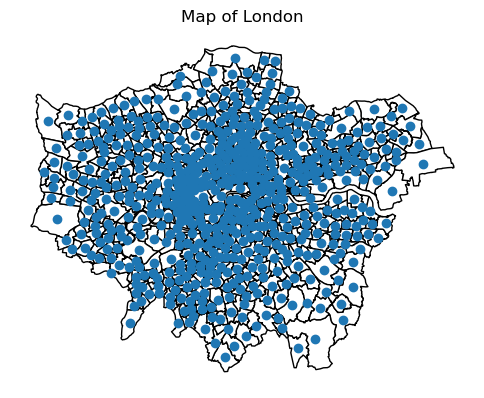

In [12]:
fig, ax = plt.subplots(figsize=(6, 6))
wards.plot(color = 'white', edgecolor = 'black', ax = ax)
wards.centroid.plot(ax=ax)
ax.set_title('Map of London', fontsize=12)
ax.axis("off")
#plt.savefig('myMap.png',dpi=150, bbox_inches='tight')
plt.show()

In [13]:
#wards = wards[~wards["OBJECTID"].isin([570, 565,113])]
wards.explore(column="burglaries", cmap="YlGnBu", legend=True)

## GWR Implementation

In [14]:
wards = wards[['burglaries',"police_station","train_stations","Value","centroid","geometry"]]
#assign predicting variable
y = wards['burglaries'].values.reshape((-1,1))
print(y.shape)
#assign factors
X = wards[["police_station","train_stations","Value"]].values
X.shape
coords = np.array(list(zip(wards.centroid.x, wards.centroid.y)))

(631, 1)


C:\Users\Hendr\AppData\Local\Temp\ipykernel_27024\3901039301.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  coords = np.array(list(zip(wards.centroid.x, wards.centroid.y)))


In [15]:
gwr_selector = Sel_BW(coords, y, X)
gwr_bw = gwr_selector.search()
#determine bandwith with bi-square kernel and AIC kriteria
print('GWR bandwidth =', gwr_bw)

GWR bandwidth = 69.0


In [21]:
#fit the model
gwr_results = GWR(coords, y, X, 69.0).fit()
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 631
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                        1920434.520
Log-likelihood:                                                   -3425.899
AIC:                                                               6859.798
AICc:                                                              6861.894
BIC:                                                            1916392.059
R2:                                                                   0.327
Adj. R2:                                                              0.324

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

https://deepnote.com/app/carlos-mendez/PYTHON-GWR-and-MGWR-71dd8ba9-a3ea-4d28-9b20-41cc8a282b7a

link handles GWR, if it compiles until here, rest can be taken from here as well

c:\Users\Hendr\.conda\envs\geospatial\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


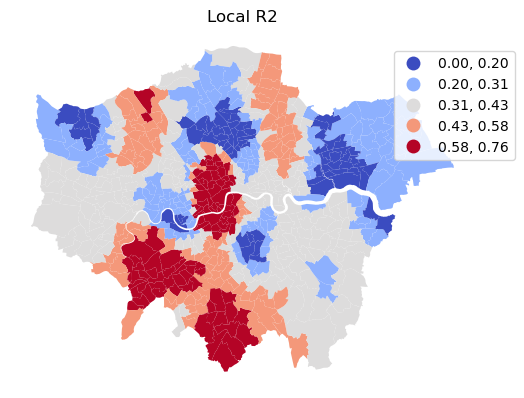

In [22]:
wards['gwr_R2'] = gwr_results.localR2

fig, ax = plt.subplots(figsize=(6, 6))
wards.plot(column='gwr_R2', cmap = 'coolwarm', linewidth=0.01, scheme = 'FisherJenks', k=5, legend=True, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=ax)
ax.set_title('Local R2', fontsize=12)
ax.axis("off")
#plt.savefig('myMap.png',dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
wards['gwr_intercept'] = gwr_results.params[:,0]
wards['gwr_police_station']  = gwr_results.params[:,1]
wards['gwr_train_station'] = gwr_results.params[:,2]
wards['gwr_house_price'] = gwr_results.params[:,3]

gwr_filtered_t = gwr_results.filter_tvals(alpha = 0.05)
print(pd.DataFrame(gwr_filtered_t))

            0         1          2         3
0    5.584173  0.000000   4.150553  2.509442
1    3.146863  0.000000   0.000000  0.000000
2    2.385253  0.000000   0.000000  0.000000
3    0.000000  0.000000   0.000000  0.000000
4    2.249231  0.000000   0.000000  0.000000
..        ...       ...        ...       ...
626  6.177405  0.000000   9.730435  0.000000
627  6.151688  0.000000   5.434619  0.000000
628  5.516298 -2.767629  18.024819  0.000000
629  3.833172  2.305222   3.598958  0.000000
630  6.619285  0.000000  14.248154  0.000000

[631 rows x 4 columns]


c:\Users\Hendr\.conda\envs\geospatial\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [24]:
wards

,burglaries,police_station,train_stations,Value,centroid,geometry,gwr_R2,gwr_intercept,gwr_police_station,gwr_train_station,gwr_house_price
0,310,0.012546,168.0,845579.0,POINT (-0.09216 51.51485),"POLYGON ((-0.09196 51.5094, -0.09523 51.51012,...",0.430381,132.398493,-963.365188,1.082094,0.000087
1,116,0.000000,13.0,230000.0,POINT (0.07817 51.53974),"MULTIPOLYGON (((0.07137 51.53725, 0.07045 51.5...",0.075445,104.789878,382.369215,0.590333,0.000019
2,70,0.004380,6.0,295000.0,POINT (0.1483 51.54559),"POLYGON ((0.15638 51.55102, 0.15649 51.54837, ...",0.185371,103.391136,-143.727991,1.574235,-0.000002
3,116,0.027545,0.0,300000.0,POINT (0.11894 51.55454),"POLYGON ((0.12502 51.56434, 0.12388 51.56195, ...",0.179305,74.601892,-133.063055,0.854251,0.000109
4,110,0.035562,0.0,300000.0,POINT (0.14 51.58476),"POLYGON ((0.13005 51.57075, 0.12993 51.57154, ...",0.254241,84.113978,54.116075,1.508589,0.000067
...,...,...,...,...,...,...,...,...,...,...,...
625,116,0.005858,5.0,1550000.0,POINT (-0.18532 51.49864),"POLYGON ((-0.18424 51.50179, -0.18031 51.50146...",0.565222,128.489084,-494.412645,6.022765,-0.000029
626,97,0.009141,7.0,1105000.0,POINT (-0.18726 51.48703),"POLYGON ((-0.19077 51.48317, -0.1936 51.48581,...",0.380657,123.320413,84.062134,4.261816,-0.000021
627,120,0.018990,7.0,1400000.0,POINT (-0.16002 51.48857),"POLYGON ((-0.15568 51.49105, -0.15517 51.49005...",0.748270,108.802523,-2356.824508,5.847884,0.000010
628,72,0.020554,0.0,715000.0,POINT (-0.21775 51.51854),"POLYGON ((-0.22245 51.51541, -0.22654 51.51958...",0.352130,98.233795,1276.236213,2.982700,-0.000006


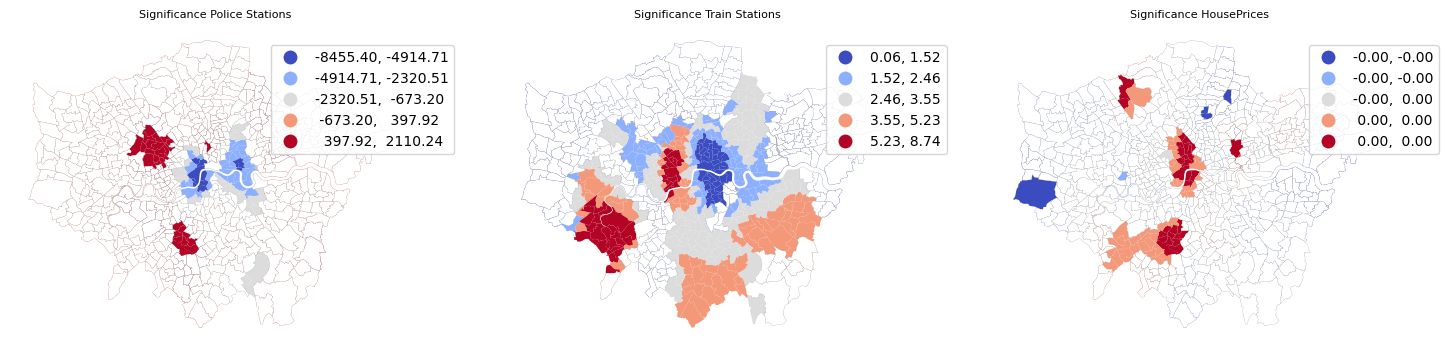

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,6))

wards.plot(column='gwr_police_station', cmap = 'coolwarm', linewidth=0.01, scheme = 'FisherJenks', legend=True,  legend_kwds={'bbox_to_anchor':(1.10, 0.96)}, ax=axes[0])
wards[gwr_filtered_t[:,1] == 0].plot(color='white', linewidth=0.05, edgecolor='black', ax=axes[0])
wards.plot(column='gwr_train_station', cmap = 'coolwarm', linewidth=0.01, scheme = 'FisherJenks', legend=True,  legend_kwds={'bbox_to_anchor':(1.10, 0.96)}, ax=axes[1])
wards[gwr_filtered_t[:,2] == 0].plot(color='white', linewidth=0.05, edgecolor='black', ax=axes[1])
wards.plot(column='gwr_house_price', cmap = 'coolwarm', linewidth=0.01, scheme = 'FisherJenks', legend=True, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=axes[2])
wards[gwr_filtered_t[:,3] == 0].plot(color='white', linewidth=0.05, edgecolor='black', ax=axes[2])

axes[0].axis("off")
axes[1].axis("off")
axes[2].axis("off")

axes[0].set_title('Significance Police Stations', fontsize=8)
axes[1].set_title('Significance Train Stations', fontsize=8)
axes[2].set_title('Significance HousePrices', fontsize=8)
plt.show()